In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [3]:
HOME = '/content/drive/MyDrive/Sign_Language'

##Paths

In [4]:
dataset = os.path.join(HOME, 'dataset/keypoint.csv')
model_save_path = os.path.join(HOME, 'models/keypoint_classifier.hdf5')
tflite_save_path = os.path.join(HOME, 'models/keypoint_classifier.tflite')

##Number of Classes

In [5]:
NUM_CLASSES = 26

##Loading the Dataset

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

##Making the Model

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((42, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(60, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    # tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [38]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_14 (Dropout)        (None, 42)                0         
                                                                 
 dense_18 (Dense)            (None, 60)                2580      
                                                                 
 dropout_15 (Dropout)        (None, 60)                0         
                                                                 
 dense_19 (Dense)            (None, 40)                2440      
                                                                 
 dropout_16 (Dropout)        (None, 40)                0         
                                                                 
 dense_20 (Dense)            (None, 26)                1066      
                                                                 
Total params: 6086 (23.77 KB)
Trainable params: 6086 (

In [39]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [40]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

##Training

In [41]:
model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=160,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
18/18 [==============================] - ETA: 0s - loss: 3.2506 - accuracy: 0.0542 
Epoch 1: saving model to /content/drive/MyDrive/Sign_Language/models/keypoint_classifier.hdf5
18/18 [==============================] - 2s 30ms/step - loss: 3.2506 - accuracy: 0.0542 - val_loss: 3.1764 - val_accuracy: 0.0775
Epoch 2/500
15/18 [========================>.....] - ETA: 0s - loss: 3.1797 - accuracy: 0.0717
Epoch 2: saving model to /content/drive/MyDrive/Sign_Language/models/keypoint_classifier.hdf5
18/18 [==============================] - 0s 7ms/step - loss: 3.1776 - accuracy: 0.0753 - val_loss: 3.1086 - val_accuracy: 0.1474
Epoch 3/500
 1/18 [>.............................] - ETA: 0s - loss: 3.1183 - accuracy: 0.1562
Epoch 3: saving model to /content/drive/MyDrive/Sign_Language/models/keypoint_classifier.hdf5
18/18 [==============================] - 0s 7ms/step - loss: 3.1004 - accuracy: 0.1143 - val_loss: 3.0098 - val_accuracy: 0.1670
Epoch 4/500
18/18 [=========================

##Evaluation

In [42]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 3ms/step - loss: 0.3487 - accuracy: 0.8974


In [43]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [44]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 81ms/step
[3.9215865e-06 1.2397454e-06 8.5053715e-04 9.2284572e-05 1.4061575e-01
 1.2338633e-04 6.9119221e-10 2.0067323e-10 3.1772188e-03 2.7490985e-11
 2.9513804e-17 6.4539411e-12 1.3145539e-07 1.0326956e-10 8.0362564e-01
 2.9523634e-11 3.2455875e-11 3.0237290e-09 5.1506009e-02 7.1983637e-09
 4.9358095e-10 2.7801375e-17 5.6475778e-07 1.8911798e-13 3.3148372e-06
 3.4812149e-12]
14


#Confusion Matrix and Classification Report

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

In [47]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

29/29 [==============================] - 0s 1ms/step


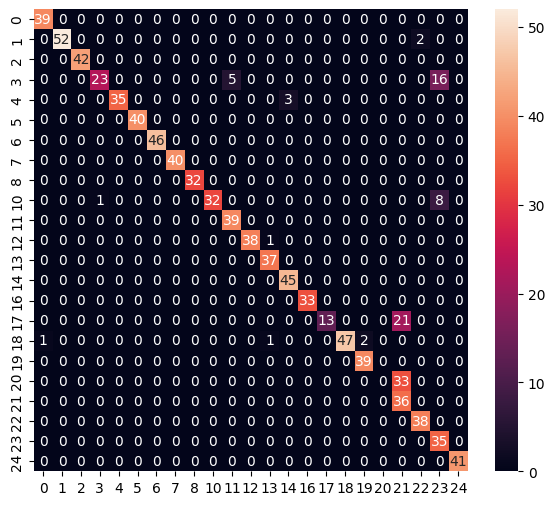

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.96      0.98        54
           2       1.00      1.00      1.00        42
           3       0.96      0.52      0.68        44
           4       1.00      0.92      0.96        38
           5       1.00      1.00      1.00        40
           6       1.00      1.00      1.00        46
           7       1.00      1.00      1.00        40
           8       1.00      1.00      1.00        32
          10       1.00      0.78      0.88        41
          11       0.89      1.00      0.94        39
          12       1.00      0.97      0.99        39
          13       0.95      1.00      0.97        37
          14       0.94      1.00      0.97        45
          16       1.00      1.00      1.00        33
          17       1.00      0.38      0.55        34
          18       1.00      0.92      0.96        51
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print_confusion_matrix(y_test, y_pred)

##Tensorflow Lite Model (convert)

In [49]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

8792

##Testing the converted model

In [51]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [52]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [53]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [54]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 174 µs, sys: 954 µs, total: 1.13 ms
Wall time: 1.19 ms


In [55]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.10590383e-06 1.24026849e-06 9.04860557e-04 1.17276300e-04
 1.39337629e-01 1.17792246e-04 1.04002207e-09 2.93484903e-10
 3.74343875e-03 3.34589439e-11 3.98591371e-17 9.72613830e-12
 1.15593103e-07 9.88560345e-11 8.09513450e-01 3.94871844e-11
 3.95880134e-11 3.34769834e-09 4.62556221e-02 9.35876177e-09
 4.56910454e-10 3.45279911e-17 5.48814398e-07 2.76728374e-13
 3.89115212e-06 4.40687721e-12]
14
